In [1]:
%load_ext autoreload
%autoreload 2
import jax
import jax.numpy as jnp
from scalable_gps import kernels
from scalable_gps import thompson_utils
from scalable_gps.models.exact_gp_model import ExactGPModel
from scalable_gps.models.cg_gp_model import CGGPModel
from scalable_gps.models.sgd_gp_model import SGDGPModel
from scalable_gps.models.vi_gp_model import SVGPThompsonInterface



In [9]:
import ml_collections
config = ml_collections.ConfigDict()

config.thompson = ml_collections.ConfigDict()
config.thompson.use_tpu = False

config.thompson.seed = 1337
config.thompson.D = 2
# config.thompson.model_name = "RandomSearch"
config.thompson.model_name = "SVGP"
config.thompson.kernel_name = "Matern32Kernel"
config.thompson.signal_scale = 1.0
config.thompson.length_scale = [0.25, 0.5]
config.thompson.noise_scale = 1e-2

config.thompson.n_features = 5000
config.thompson.n_init = 5
config.thompson.n_friends = 3000
config.thompson.n_homies = 10
config.thompson.n_besties = 1

config.thompson.n_samples = 20

config.thompson.find_friends_method = 'uniform'
config.thompson.optim_lr = 1e-3
config.thompson.optim_iters = 100

config.thompson.grid_search_dim = 400

config.thompson.minval = 0.
config.thompson.maxval = 1.


####### CG #

config.cg_config = ml_collections.ConfigDict()
config.cg_config.tol = 1e-3
config.cg_config.maxiter = 1000
config.cg_config.atol = 0.
config.cg_config.eval_every = 1
config.cg_config.preconditioner = False
config.cg_config.pivoted_chol_rank = 100
config.cg_config.pivoted_diag_rtol = 1e-3
config.cg_config.pivoted_jitter = 1
config.cg_config.loss_objective = 2

config.cg_config.batch_size = 1 


### SGD #

config.train_config = ml_collections.ConfigDict()

config.train_config.iterations = 10000
config.train_config.batch_size = 500
config.train_config.eval_every = -1

# RFF Configs
config.train_config.n_features_optim = 100
config.train_config.recompute_features = True
# Optimisation Configs
config.train_config.iterative_idx = True
config.train_config.learning_rate = 1e-1
config.train_config.momentum = 0.9
config.train_config.nesterov = True
config.train_config.time_budget_in_seconds = -1
config.train_config.eval_every_in_seconds = None
polyak_k = 100
polyak_step = polyak_k / config.train_config.iterations
config.train_config.polyak = polyak_step
config.train_config.absolute_clipping = 0.1  # -1 to avoid clipping
config.train_config.lr_schedule_name = None # "linear_schedule"
config.train_config.lr_schedule_config = ml_collections.ConfigDict()


# sampling 

config.sampling_config = ml_collections.ConfigDict()

config.sampling_config = config.train_config.copy_and_resolve_references()
# Full-batch training configs that get passed
config.sampling_config.iterative_idx = True
config.sampling_config.learning_rate = 3e-4
config.sampling_config.batch_size = 500
config.sampling_config.eval_every = -1 # eval every how many number of steps 


config.sampling_config.loss_objective = 2

# VI

config.vi_config = ml_collections.ConfigDict()
config.vi_config = config.thompson.copy_and_resolve_references()

config.vi_config.iterations = 5000
config.vi_config.batch_size = 100
config.vi_config.num_inducing_points = 512
config.vi_config.inducing_init = "uniform"
config.vi_config.learning_rate = 1e-2
config.vi_config.absolute_clipping = 0.1
config.kernel_name = config.thompson.kernel_name




In [10]:
kernel_init_fn = getattr(kernels, config.thompson.kernel_name)
kernel = kernel_init_fn({'signal_scale': config.thompson.signal_scale, 'length_scale': jnp.array(config.thompson.length_scale)})
kernel.kernel_config['use_ard'] = len(config.thompson.length_scale) > 1


key = jax.random.PRNGKey(config.thompson.seed)
init_key, optim_key = jax.random.split(key)
state = thompson_utils.init(init_key, config.thompson.D, kernel,
                             n_features=config.thompson.n_features, n_init=config.thompson.n_init,
                               noise_scale=config.thompson.noise_scale,
                               minval=config.thompson.minval, maxval=config.thompson.maxval)
print(state.max_fn_value)


0.36021465


## full Thompson loop

In [11]:

if config.thompson.model_name == "ExactGP":
    model = ExactGPModel(config.thompson.noise_scale, kernel)
    train_config, sampling_config = None, None
elif config.thompson.model_name == "CGGP":
    model = CGGPModel(config.thompson.noise_scale, kernel)
    train_config, sampling_config = config.cg_config, config.cg_config
elif config.thompson.model_name == "SGDGP":
    model = SGDGPModel(config.thompson.noise_scale, kernel)
    train_config, sampling_config = config.train_config, config.sampling_config
elif config.thompson.model_name == "SVGP":
    model = SVGPThompsonInterface(config.thompson.noise_scale, kernel, config)
    train_config, sampling_config = config.vi_config, config.vi_config

print(model)

step = thompson_utils.get_thompson_step_fn(config.thompson, train_config, sampling_config, model)
key = optim_key
for i in range(10):
    key, _ = jax.random.split(key)
    state = step(key, state)
    print(state.max_fn_value, state.ds.x.shape, state.argmax)


  0%|          | 0/5000 [00:00<?, ?it/s]

1.1090165 (25, 2) [0.80415165 0.9515253 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

1.1090165 (45, 2) [0.80415165 0.9515253 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

1.1090165 (65, 2) [0.80415165 0.9515253 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

1.1090165 (85, 2) [0.80415165 0.9515253 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

1.1428504 (105, 2) [0.80968744 0.9602397 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

1.1457121 (125, 2) [0.82601047 1.        ]


  0%|          | 0/5000 [00:00<?, ?it/s]

1.177081 (145, 2) [0.81904465 0.9648736 ]


  0%|          | 0/5000 [00:00<?, ?it/s]

1.1886789 (165, 2) [0.8218884 0.9618924]


  0%|          | 0/5000 [00:00<?, ?it/s]

1.1886789 (185, 2) [0.8218884 0.9618924]


  0%|          | 0/5000 [00:00<?, ?it/s]

1.1886789 (205, 2) [0.8218884 0.9618924]


In [7]:
grid_max_fn_value, grid_argmax = thompson_utils.grid_search(
    state, minval=config.thompson.minval, maxval=config.thompson.maxval, grid_dim=config.thompson.grid_search_dim
    )

print(f"Grid max_fn_value = {grid_max_fn_value}")
print(f"Grid argmax = {grid_argmax}")


Grid max_fn_value = 1.1796261072158813
Grid argmax = [0.82205516 0.9799499 ]


## single step illustration

In [ ]:
### ExactGP
from scalable_gps.models.exact_gp_model import ExactGPModel

exact_gp = ExactGPModel(noise_scale=noise_scale, kernel=kernel)
alpha_map = exact_gp.compute_representer_weights(state.ds)
print(alpha_map.shape)

friends_key = jax.random.PRNGKey(42)
ds_friends = thompson_utils.find_friends(friends_key, state, n_friends)
n_features = state.L.shape[-1]
L_friends = state.kernel.feature_fn(None, n_features, ds_friends.x, recompute=False)
L = jnp.concatenate([state.L, L_friends], axis=0)
print(L.shape)

samples_key = jax.random.PRNGKey(1337)
ds_friends.y, alpha_samples, w_samples = exact_gp.compute_posterior_samples(samples_key, n_samples, state.ds, ds_friends, use_rff=True, L=L, zero_mean=False)
print(ds_friends.y.shape, alpha_samples.shape, w_samples.shape)

x_homies = thompson_utils.find_homies(ds_friends, n_homies)

acquisition_fn, acquisition_grad = thompson_utils.get_acquisition_fn(state, alpha_map, alpha_samples, w_samples)
x_besties, trace = thompson_utils.find_besties(x_homies, acquisition_fn, acquisition_grad,
                                               learning_rate=optim_lr, iterations=optim_iters,
                                               n_besties=n_besties, optim_trace=True)

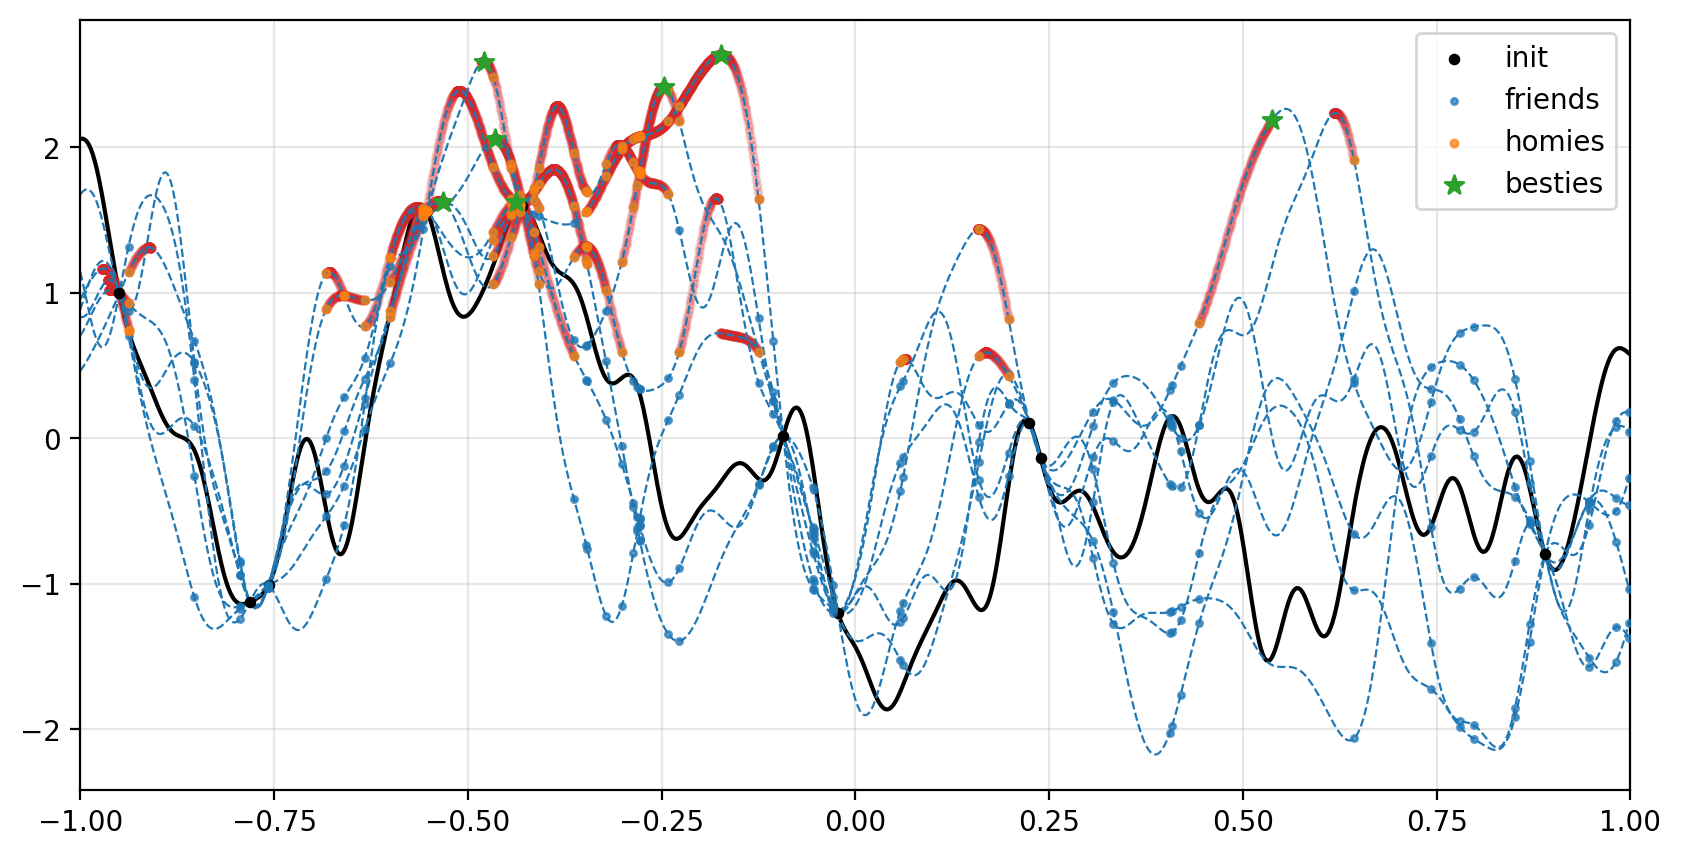

In [ ]:
import matplotlib.pyplot as plt

n_plot = 1000
x_plot = jnp.linspace(-1, 1, num=n_plot)[:, None]
L_plot = state.kernel.feature_fn(None, n_features, x_plot, recompute=False)
y_plot = L_plot @ state.w

fig = plt.figure(dpi=200, figsize=[10, 5])
ax = fig.add_subplot(111)
ax.set_xlim(-1, 1)
ax.plot(x_plot, y_plot, color='k')
ax.scatter(state.ds.x, state.ds.y, color='k', marker='o', s=10, zorder=3, label='init')
ax.scatter(ds_friends.x.repeat(n_samples, axis=0), ds_friends.y.T.ravel(), color='tab:blue', marker='o', s=5, zorder=3, alpha=0.7, label='friends')
ax.scatter(x_homies, acquisition_fn(x_homies), color='tab:orange', marker='o', s=7, zorder=3, alpha=0.7, label='homies')
for (x, y) in trace:
    ax.scatter(x, y, color='tab:red', marker='o', s=7, zorder=2, alpha=0.2)
ax.scatter(x_besties, acquisition_fn(x_besties), color='tab:green', marker='*', s=50, zorder=4, label='besties')
ax.plot(x_plot, acquisition_fn(x_plot[None, :].repeat(n_samples, axis=0)).T, color='tab:blue', linestyle='--', linewidth=0.8)
ax.grid(alpha=0.3, zorder=0)
ax.legend()